In [2]:
#################################################################################################
# THIS IS THE ONE THAT WORKS DO NOT DELETE
# sets up a keysight frequency counter to trigger on external voltage change
# collects data from the onboard buffer every few seconds saving to CSV file
#################################################################################################

import nidaqmx
import time
import pyvisa as visa
import pandas as pd
import Utilities as util
from os import path
from pymeasure.instruments.keithley import Keithley2000
from pymeasure.adapters import PrologixAdapter
import math

########################################## Helper functions go here ##############################################################################
def getTrigCountCmd(num):
    trig_num_cmd = 'TRIG:COUN ' + str(num)
    return trig_num_cmd

def getTrigSourceCmd(sr):
    trig_src_cmd = 'TRIG:SOUR '+ sr
    return trig_src_cmd

def collectionTimeToNumCycles(col_time, trig_count, lowtime, hightime):
    time_per_point = lowtime + hightime
    time_per_cycle = time_per_point * trig_count
    num_cycles = col_time/time_per_cycle
    #round up, to the nearest int
    num_cycles = math.ceil(num_cycles)
    return int(num_cycles)
####################################################################################################################################################


######################################### Set the your collection variables here ###################################################################
#
# trig_count = the number of measurements collected before that data is offloaded to a csv file
# trig_count_cmd = a SCPI command created from the specified trigger count
# trig_source = the trigger source for the instruments. It can be IMM, EXT, BUS, etc. For this it should be EXT
# trig_source_cmd = a SCPI command created from the specified trigger source
# high_V = the high voltage value to send as a trigger from the DAQ
# low_V = the low voltage value to send as a trigger from the DAQ, this should be 0.0
# high_time = the amount of time in seconds to send the high voltage 
# low_time = the amount of time in seconds to send the low voltage 
# how_long_collec = the length of time you want to collect data for in seconds, this will be used to determine how many cycles to collect for.
# how_many_cycles = this is determined from the length of time it takes to collect one data point, and how long the user wishes to collec data for.
# folder = where do you want data files to be saved? remember to escape back slashes on windows
#
#####################################################################################################################################################
trig_count = 10
trig_count_cmd = getTrigCountCmd(trig_count)
trig_source = 'EXT'
trig_source_cmd = getTrigSourceCmd(trig_source)
high_V = 2.5
low_V = 0.0
high_time = 0.5
low_time = 0.5
how_long_collect = 20
how_many_cycles = collectionTimeToNumCycles(how_long_collect, trig_count, low_time, high_time)
folder = 'Data\\kseExperiment\\'

keysight_addr = 'USB0::0x0957::0x1807::MY58430132::INSTR' #name/address for the keysight connected to the computer
daq_path = 'Dev2/ao0' #the path to the daq
dmm_addr = 'ASRL6::INSTR' #address of USB connected to computer
gpib_channel_no = 1 #the channel number for the GPIB connection from the dmm. this can be set on the dmm to anything between 1 and 16


####################################################################################################################################################
# Data Collection starts here!
####################################################################################################################################################

print('Collecting data for '+str(how_many_cycles)+' cycles.')

#do all the document prep at the beginning so it doesn't slow down collection later
#create a new csv file at the specified location
filename = util.dtStringForFilename()
fp = folder + filename
file = open(fp, 'a')
#create an empty data frame and save the headers to the file
df_headers = pd.DataFrame({'Frequencies': [], 'Voltages': [], 'Times':[], 'Timestamps':[]})
df_headers.to_csv(fp, mode='a', index=False)
print('Output file created')

# open the resource manager so we can connect to the keysight and the keithley
rm = visa.ResourceManager()



# Keysight connection setup
freq_counter = rm.open_resource(keysight_addr)
freq_counter.encoding = 'latin_1'
freq_counter.source_channel = 'CH1'

# Keysight data collection set up
## reset everything and clear the event queues
freq_counter.write('*RST')
freq_counter.write('STAT:PRES')
freq_counter.write('*CLS')
## set the type of measurement to frequency
freq_counter.write('CONF:FREQ')
freq_counter.write(trig_source_cmd)
freq_counter.write('TRIG:SLOP POS')
freq_counter.write(trig_count_cmd)

# DAQ Setup and task initialization
task = nidaqmx.Task()
task.ao_channels.add_ao_voltage_chan(daq_path)
print('Starting Collection')
task.start()
task.write(0.0)#make sure we are starting at 0V

# Initialize the keysight
#freq_counter.write('INIT')

# Continuing the things I hate, I have to wait until after the garbage cycle completes on the keysight to set up the dmm
# because if I don't it gets into a mystery state where it doesn't understand how to send data properly and I don't know why
# I would like to fix this correctly by figuring out how to reliably reset the dmm to the state it is in at power up, but since I 
# have yet to figure that out, we're doing this stupid work around
#Keithley dmm connection set up

adapter = PrologixAdapter(dmm_addr, gpib_channel_no) #create prologix adapter and connect to GPIB w/ address 1
dmm = Keithley2000(adapter) #create the instrument using the adapter

# Keithley data collection set up
## reset everything and clear the event queues
dmm.reset()
## need to set trigger type to external
dmm.write(trig_source_cmd)
## set trigger count to the desired number of datapoints per collection cycle
dmm.write(trig_count_cmd)
## set sample count to 1 (this is one sample per trigger)
dmm.write('SAMP:COUN 1')


cycle_num=1

while (cycle_num<=how_many_cycles):
    freq_counter.write('INIT')
    #do one trigger cycle to get rid of the empty data point that apparently gets collected for reasons?
    #I hate that this is a thing, but it appears to be a thing, so we're going to roll with it
    task.write(2.0)
    time.sleep(0.1)
    task.write(0.0)
    time.sleep(0.1)
    freq_counter.query('R?')#remove the empty data point from the data register, so our time stamps will match up with the frequencies collected
    
    # set up the data trace so I can get more than one mesurement when we reach the end of the collection cycle
    # I have to do this here so all the data points stay in sync because of the weird empty value the keysight likes to for it's first trigger cycle
    cmd_trace = 'TRAC:POIN ' + str(trig_count)
    dmm.write(cmd_trace)
    dmm.write('TRAC:FEED SENS1;FEED:CONT NEXT')
    dmm.write('INIT')

    print('Starting Data Collection Cycle '+str(cycle_num))
    times = [] #the timestamps will go here
    frequencies = ''
    dmm_vals = ''
    
    #times = daqUtils.genAnalogTriggerCycle(task, trig_count, high_V, low_V, high_time, low_time)
    i=0
    while (i<trig_count):
        task.write(high_V) #high voltage value to send (probably stay below 5V in general)
        times.append(time.time())
        time.sleep(high_time) #how long do we want to stay at the hight voltage
        task.write(low_V) #usually this will be 0V
        time.sleep(low_time) #how long do we want to stay at the low voltage
        i = i+1

    print('Ending Collection Cycle '+str(cycle_num))

    try:
        frequencies = freq_counter.query('FETC?')
    except: 
        print('I regret to inform you that something done f*cked up with the Keysight and there is no data.')
        print('Ending data collection.')
        task.close()
        freq_counter.close()
        adapter.close()
        rm.close()

    try: 
        dmm_vals = dmm.ask('TRAC:DATA?')
    except:  
        print('I regret to inform you that something done f*cked up with the Keysight and there is no data.')
        print('Ending data collection.')
        task.close()
        freq_counter.close()
        adapter.close()
        rm.close()   

    #now I need to make the data into some sort of format that we can easily put in a text file
    frequencies = util.stringToPandasSeries(frequencies, ',')
    dmm_vals = util.stringToPandasSeries(dmm_vals, ',')
    hrdates, hrtimes = util.formatTimestampsForCSV(times)
    
    df = pd.DataFrame({
        'Frequency': frequencies,
        'Voltage': dmm_vals,
        'Time': hrtimes, 
        'Timestamps': times
    })
    df.to_csv(fp, mode='a', index=False, header=False)
    cycle_num = cycle_num+1
    
#close the DAQ taks
task.close()
#close the csv file
file.close()
#close the connections
openres = rm.list_opened_resources()
print('Closing Connection with ', openres)
freq_counter.close()
adapter.close()
rm.close()




Output file created
Starting Collection
Starting Data Collection Cycle 1
Ending Collection Cycle 1
Starting Data Collection Cycle 2
Ending Collection Cycle 2
Starting Data Collection Cycle 3
Ending Collection Cycle 3
Starting Data Collection Cycle 4
Ending Collection Cycle 4
Starting Data Collection Cycle 5
Ending Collection Cycle 5
Starting Data Collection Cycle 6
Ending Collection Cycle 6
Starting Data Collection Cycle 7
Ending Collection Cycle 7
Starting Data Collection Cycle 8
Ending Collection Cycle 8
Starting Data Collection Cycle 9
Ending Collection Cycle 9
Starting Data Collection Cycle 10
Ending Collection Cycle 10
Starting Data Collection Cycle 11
Ending Collection Cycle 11
Starting Data Collection Cycle 12
Ending Collection Cycle 12
Starting Data Collection Cycle 13
Ending Collection Cycle 13
Starting Data Collection Cycle 14
Ending Collection Cycle 14
Starting Data Collection Cycle 15
Ending Collection Cycle 15
Starting Data Collection Cycle 16
Ending Collection Cycle 16
St

In [1]:
#################################################################################################
# Voltage testing module
# this module connects to the DAQ and creates an analog output task
# that task then sends 2V through the analog output for a few seconds before returning to 0V
# the purpose is to allow for testing of external triggers without having to hook up the actual instruments themselves
#################################################################################################

import nidaqmx
import time


task = nidaqmx.Task()
task.ao_channels.add_ao_voltage_chan("Dev2/ao0")
task.start()
task.write(0.0)#make sure we are starting at 0V
time.sleep(1)

#do one trigger cycle to get rid of the empty data point that apparently gets collected for reasons?
#I hate that this is a thing, but it appears to be a thing, so we're going to roll with it
print("sending 2V now")
task.write(2.0)
time.sleep(5)
task.write(0.0)
time.sleep(1)
task.stop()


#close the DAQ taks
task.close()


sending 2V now


In [5]:
#################################################################################################
# Available connections module
# 
# This module lists the available daw connections via the nidaqmx libray and the available 
# instruments via the pyvisa library. Use this to check the names and paths to your instruments
# when setting up data collection. 
#################################################################################################

import nidaqmx.system as sys
import pyvisa as visa

system = sys.System.local()

print('Available daq physical analog output channels: ')
for device in system.devices: 
    print(device.ao_physical_chans.channel_names)

print()

rm = visa.ResourceManager()
res = []
for r in rm.list_resources():
    res.append(r)

print(rm.list_resources_info())

print('Available instrument resources: ')
print(res)
rm.close()


Available daq physical analog output channels: 
['Dev1/ao0', 'Dev1/ao1']

{'USB0::0x0957::0x1807::MY58430132::INSTR': ResourceInfo(interface_type=<InterfaceType.usb: 7>, interface_board_number=0, resource_class='INSTR', resource_name='USB0::0x0957::0x1807::MY58430132::0::INSTR', alias=None), 'USB0::0x0699::0x0368::C041014::INSTR': ResourceInfo(interface_type=<InterfaceType.usb: 7>, interface_board_number=0, resource_class='INSTR', resource_name='USB0::0x0699::0x0368::C041014::0::INSTR', alias=None), 'ASRL6::INSTR': ResourceInfo(interface_type=<InterfaceType.asrl: 4>, interface_board_number=6, resource_class='INSTR', resource_name='ASRL6::INSTR', alias='COM6')}
Available instrument resources: 
['USB0::0x0957::0x1807::MY58430132::INSTR', 'USB0::0x0699::0x0368::C041014::INSTR', 'ASRL6::INSTR']


In [2]:
#################################################################################################
# Data Processing Module
#
# Converts raw frequency data collected above to a csv file with the following conversions
#      - timestamps -> change in time from start
#      - dmm voltage -> change in frequency 
#      - adds a column for keysight_freq - dmm_freq 
#################################################################################################

import KSEExperimentUtils as kse

ext = ".csv"

filename_raw = "Data\\2024-06-26-11_45_55.085837"
filepath_raw = filename_raw + ext
filepath_cleaned = filename_raw + "_cleaned"+ext
filepath_converted = filename_raw + "_processed"+ext


#first remove any columns with DMM overflow values
cleaned = kse.removeDMMOverflowVals(filepath_raw)
kse.createCSVProcessedData(filepath_cleaned, cleaned)

# second parameter must be one of 'rb85', 'rb87', or 'cs133'
# third paramtere must be one of 'high', 'low'
processed_data = kse.processAllData(filepath_cleaned, 'rb85', 'high')
kse.createCSVProcessedData(filepath_converted, processed_data)


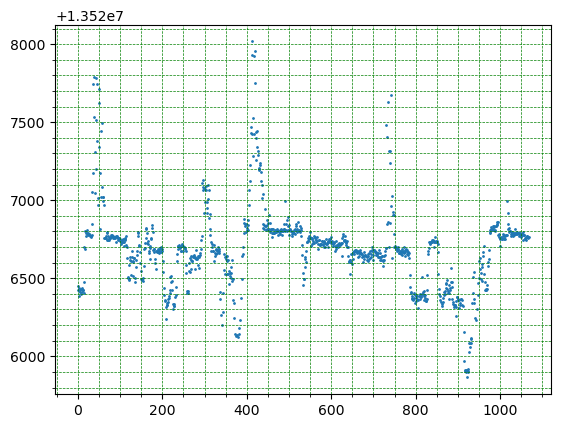

In [5]:
#################################################################################################
# Plot Module
#
# Plots frequency data from converted csv files
#################################################################################################

import pandas as pd
import numpy as np
import KSEExperimentUtils as kse
import matplotlib.pyplot as plt

dot_size = 1
grid_color = 'green'

def setUpPlot():
    plt.grid(which = 'major', color = grid_color, linestyle = '--', linewidth = '0.5')
    plt.grid(which = 'minor', color = grid_color, linestyle = '--', linewidth = '0.5')
    plt.minorticks_on()

filepath_converted = "Data\\2024-06-26-11_45_55.085837_processed.csv"

data = pd.read_csv(filepath_converted)

arr_size = len(data['Time'])

times = np.zeros(arr_size)
ks_freq = np.zeros(arr_size)
dmm_freq = np.zeros(arr_size)
ks_adj = np.zeros(arr_size)

for i in range(0, arr_size):
    times[i] = float(data['Time'][i])
    ks_freq[i] = float(data['Keysight'][i])
    dmm_freq[i] = float(data['DMM'][i])
    ks_adj[i] = float(data['Adjusted Keysight Data'][i])

setUpPlot()
plt.scatter(times, ks_adj, s=dot_size)
plt.scatter(times, ks_freq, s=dot_size, color = 'orange')


In [1]:
import KSEExperimentUtils as kse
import pandas as pd

filepath = 'Data\\kseExperiment\\2024-06-20-15_20_35.940986'

data = pd.read_csv(filepath)

to_rm = kse.findDMMOverflowVals(data)

print(to_rm)

updated = kse.removeDMMOverflowVals(data)
print(updated)

[0, 2, 10, 12, 20, 22, 30, 32, 40, 42, 50, 52, 60, 62, 70, 72, 80, 82, 90, 92, 100, 102, 110, 112, 120, 122, 130, 132, 140, 142, 150, 152, 160, 162, 170, 172, 180, 182, 190, 192, 200, 202, 210, 212, 220, 222, 230, 232, 240, 242, 250, 252, 260, 262, 270, 272, 280, 282, 290, 292, 300, 302, 310, 312, 320, 322, 330, 332, 340, 342, 350, 352, 360, 362, 370, 372, 380, 382, 390, 392, 400, 402, 410, 412, 420, 422, 430, 432, 440, 442, 450, 452, 460, 462, 470, 472, 480, 482, 490, 492, 500, 502, 510, 512, 520, 522, 530, 532, 540, 542, 550, 552, 560, 562, 570, 572, 580, 582, 590, 592, 600, 602, 610, 612, 620, 622, 630, 632, 640, 642, 650, 652, 660, 662, 670, 672, 680, 682, 690, 692, 700, 702, 710, 712, 720, 722, 730, 732, 740, 742, 750, 752, 760, 762, 770, 772, 780, 782, 790, 792, 800, 802, 810, 812, 820, 822, 830, 832, 840, 842, 850, 852, 860, 862, 870, 872, 880, 882, 890, 892, 900, 902, 910, 912, 920, 922, 930, 932, 940, 942, 950, 952, 960, 962, 970, 972, 980, 982, 990, 992, 1000, 1002, 1010, 101